In [1]:
from fit import *
import matplotlib.pyplot as plt
%matplotlib widget
from utils import plot_event, plot_generator, get_data_files, preceding_noise_file

First set up the MC configuration, i.e. the data part for which we're simulating data.

In [2]:
data_date_and_time = '20190504034237'
data_files = get_data_files(data_date_and_time)
noise_files = [preceding_noise_file(f) for f in data_files]
cfg = CounterConfig(data_files, noise_files)

Now let's simulate an event with given shower parameters.

In [3]:
pars = [500.,2.e6,np.deg2rad(40.),np.deg2rad(315.), 450., -660.,-25.7,0,70,100.]
ev = BasicParams.get_event(pars)
pe = ProcessEvents(cfg, frozen_noise=True)
real_nfits = pe.gen_nfits_from_event(ev)
print(ev)

Event(E=1538461538461538.5, Xmax=500.0, Nmax=2000000.0, zenith=0.6981317007977318, azimuth=5.497787143782138, corex=450.0, corey=-660.0, corez=-25.7, X0=0, Lambda=70)


We now have fitted NICHE waveforms, so we can estimate the core position with a tyro fit, and perform a plane fit to estimate the shower direction. We then compile this info into inital guesses to supply to the minimizer.

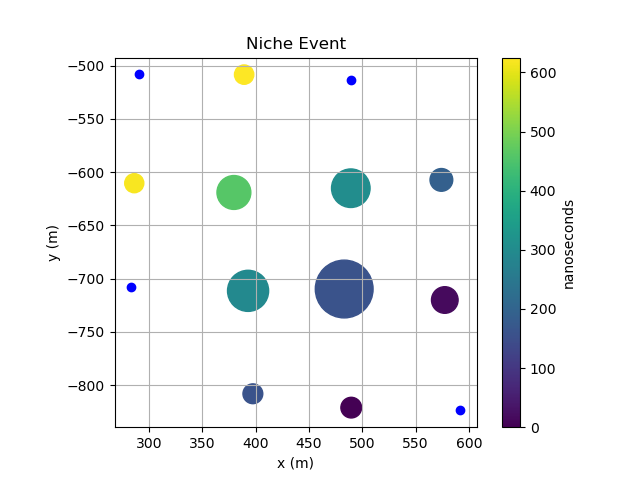

In [4]:
ty = tyro(real_nfits)
pf = NichePlane(real_nfits)
plot_event(ty)

In [5]:
guess = make_guess(ty, pf)
# for i,p in enumerate(guess):
#     guess[i].value = pars[i]
[print(p) for p in guess];

FitParam(name='xmax', value=400.0, limits=(300.0, 600.0), error=50.0, fixed=False)
FitParam(name='nmax', value=1000000.0, limits=(100000.0, 10000000.0), error=100000.0, fixed=False)
FitParam(name='zenith', value=0.7250494694271545, limits=(0.6250494694271546, 0.8250494694271545), error=0.017453292519943295, fixed=False)
FitParam(name='azimuth', value=5.467723375601067, limits=(5.367723375601067, 5.567723375601067), error=0.017453292519943295, fixed=False)
FitParam(name='corex', value=448.8105322878261, limits=(379.5, 489.2), error=5.0, fixed=False)
FitParam(name='corey', value=-678.165012254245, limits=(-711.4, -615.1), error=5.0, fixed=False)
FitParam(name='corez', value=-25.7, limits=(-25.7, -25.7), error=1.0, fixed=True)
FitParam(name='x0', value=0.0, limits=(0, 0), error=1, fixed=True)
FitParam(name='lambda', value=70.0, limits=(70.0, 70.0), error=1, fixed=True)
FitParam(name='t_offset', value=100.0, limits=(0, 150.0), error=10.0, fixed=False)


Fitting for the log of xmax and nmax rather than the values themselves results in a better fit, so we use the BasicParams mapper to go between the fitted parameters and the real ones.

In [6]:
guess = BasicParams.adjust_guess(guess)
# guess = pars

Now we can begin the fit procedure, starting by fitting the peaktimes for the shower angles.

In [7]:
pt = PeakTimes(real_nfits, BasicParams, cfg)
pt.target_parameters = ['zenith','azimuth']
m = init_minuit(pt, guess)
m.tol = .1
m.simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 10.05 (χ²/ndof = 1.3)      │              Nfcn = 42               │
│ EDM = 0.0157 (Goal: 0.1)         │           time = 75.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    400    │    50     │            │            │   300   │   600   │  yes  │
│ 1 │ nmax     │   1.0e6   │   0.1e6   │            │            │ 100000  │  1e+07  │  yes  │
│ 2 │ zenith   │ 697.0e-3  │  0.5e-3   │            │            │0.625049 │0.825049 │       │
│ 3 │ azimuth  │ 5.502192  │ 0.000015  │            │            │ 5.36772 │ 5.56772 │       │
│ 4 │ corex    │    449    │     5     │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │   -678    │     5     │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez    │   -25.7   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │    100    │    10     │            │            │    0    │   150   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now with a good estimate for the angles, we can fit the pulse widths to estimate xmax.

In [8]:
tpguess = update_guess(m)
pw = PulseWidth(real_nfits, BasicParams, cfg)
pw.target_parameters = ['xmax']
m = init_minuit(pw, tpguess)
m.simplex(ncall=40)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 11.96 (χ²/ndof = 1.3)      │              Nfcn = 11               │
│ EDM = 0.00825 (Goal: 0.1)        │           time = 16.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    450    │    40     │            │            │   300   │   600   │       │
│ 1 │ nmax     │   1.0e6   │   0.1e6   │            │            │ 100000  │  1e+07  │  yes  │
│ 2 │ zenith   │ 697.0e-3  │  0.5e-3   │            │            │0.625049 │0.825049 │  yes  │
│ 3 │ azimuth  │ 5.502192  │ 0.000015  │            │            │ 5.36772 │ 5.56772 │  yes  │
│ 4 │ corex    │    449    │     5     │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │   -678    │     5     │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez    │   -25.7   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │    100    │    10     │            │            │    0    │   150   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now, with a good estimate for log(xmax), we can fit the integrated pulse areas for nmax.

In [9]:
xmaxguess = update_guess(m)
pa = PulseArea(real_nfits, BasicParams, cfg)
pa.target_parameters = ['nmax']
m = init_minuit(pa, xmaxguess)
m.simplex(ncall=20)

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 293.5 (χ²/ndof = 32.6)     │              Nfcn = 20               │
│ EDM = 0.0236 (Goal: 0.1)         │           time = 31.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │    450    │    40     │            │            │   300   │   600   │  yes  │
│ 1 │ nmax     │  2.23e6   │  0.05e6   │            │            │ 100000  │  1e+07  │       │
│ 2 │ zenith   │ 697.0e-3  │  0.5e-3   │            │            │0.625049 │0.825049 │  yes  │
│ 3 │ azimuth  │ 5.502192  │ 0.000015  │            │            │ 5.36772 │ 5.56772 │  yes  │
│ 4 │ corex    │    449    │     5     │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │   -678    │     5     │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez    │   -25.7   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │    100    │    10     │            │            │    0    │   150   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

Now, with these values in the ballpark, we can simultaneously minimize both the shower profile and core position by fitting the normalized pulse areas.

In [10]:
nmaxguess = update_guess(m)
pa = NormalizedPulseArea(real_nfits, BasicParams, cfg)
pa.target_parameters = ['xmax','nmax','corex','corey']
m = init_minuit(pa, nmaxguess)
m.simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.81 (χ²/ndof = 3.0)      │              Nfcn = 73               │
│ EDM = 0.0635 (Goal: 0.1)         │           time = 107.7 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │   492.0   │    2.7    │            │            │   300   │   600   │       │
│ 1 │ nmax     │  2.122e6  │  0.017e6  │            │            │ 100000  │  1e+07  │       │
│ 2 │ zenith   │ 697.0e-3  │  0.5e-3   │            │            │0.625049 │0.825049 │  yes  │
│ 3 │ azimuth  │ 5.502192  │ 0.000015  │            │            │ 5.36772 │ 5.56772 │  yes  │
│ 4 │ corex    │   449.6   │    1.3    │            │            │  379.5  │  489.2  │       │
│ 5 │ corey    │  -658.7   │    1.6    │            │            │ -711.4  │ -615.1  │       │
│ 6 │ corez    │   -25.7   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │    100    │    10     │            │            │    0    │   150   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [11]:
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.81 (χ²/ndof = 3.0)      │              Nfcn = 120              │
│ EDM = 1.43e+04 (Goal: 0.1)       │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │  492.02   │   0.05    │            │            │   300   │   600   │       │
│ 1 │ nmax     │ 2.1215e6  │ 0.0011e6  │            │            │ 100000  │  1e+07  │       │
│ 2 │ zenith   │ 697.0e-3  │  0.5e-3   │            │            │0.625049 │0.825049 │  yes  │
│ 3 │ azimuth  │ 5.502192  │ 0.000015  │            │            │ 5.36772 │ 5.56772 │  yes  │
│ 4 │ corex    │    450    │    60     │            │            │  379.5  │  489.2  │       │
│ 5 │ corey    │  -658.73  │   0.33    │            │            │ -711.4  │ -615.1  │       │
│ 6 │ corez    │   -25.7   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │    100    │    10     │            │            │    0    │   150   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│          │     xmax     nmax   zenith  azimuth    corex    corey    corez       x0   lambda t_offset │
├──────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│     xmax │  0.00207  10.6819   0.0000   0.0000  -3.8739   0.0069   0.0000   0.0000   0.0000   0.0000 │
│     nmax │  10.6819 1.31e+06        0        0 -0.094e6   168.45        0        0        0        0 │
│   zenith │   0.0000        0        0        0        0     0.00        0        0        0        0 │
│  azimuth │   0.0000        0        0        0        0     0.00        0        0        0        0 │
│    corex │  -3.8739 -0.094e6        0        0 3.41e+04   -60.95        0        0        0        0 │
│    corey │   0.0069   168.45     0.00     0.00   -60.95    0.109     0.00     0.00     0.00     0.00 │
│    corez │   0.0000        0        0        0        0     0.00        0        0        0        0 │
│       x0 │   0.0000        0        0        0        0     0.00        0        0        0        0 │
│   lambda │   0.0000        0        0        0        0     0.00        0        0        0        0 │
│ t_offset │   0.0000        0        0        0        0     0.00        0        0        0        0 │
└──────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

Now that we're reasonably close to the minimum, we can zero in on it by freeing all the parameters simultaneously.

In [12]:
guess = update_guess(m)
at = AllSamples(real_nfits, BasicParams, cfg)
at.target_parameters = ['t_offset']
m = init_minuit(at, guess)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 673 (χ²/ndof = 3.4)        │              Nfcn = 45               │
│ EDM = 3.52e-08 (Goal: 0.0002)    │           time = 62.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │  492.02   │   0.05    │            │            │   300   │   600   │  yes  │
│ 1 │ nmax     │ 2.1215e6  │ 0.0011e6  │            │            │ 100000  │  1e+07  │  yes  │
│ 2 │ zenith   │ 697.0e-3  │  0.5e-3   │            │            │0.625049 │0.825049 │  yes  │
│ 3 │ azimuth  │ 5.502192  │ 0.000015  │            │            │ 5.36772 │ 5.56772 │  yes  │
│ 4 │ corex    │    450    │    60     │            │            │  379.5  │  489.2  │  yes  │
│ 5 │ corey    │  -658.73  │   0.33    │            │            │ -711.4  │ -615.1  │  yes  │
│ 6 │ corez    │   -25.7   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │ 82.40461  │  0.00011  │            │            │    0    │   150   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│          │     xmax     nmax   zenith  azimuth    corex    corey    corez       x0   lambda t_offset │
├──────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│     xmax │        0        0        0        0        0        0        0        0        0        0 │
│     nmax │        0        0        0        0        0        0        0        0        0        0 │
│   zenith │        0        0        0        0        0        0        0        0        0        0 │
│  azimuth │        0        0        0        0        0        0        0        0        0        0 │
│    corex │        0        0        0        0        0        0        0        0        0        0 │
│    corey │        0        0        0        0        0        0        0        0        0        0 │
│    corez │        0        0        0        0        0        0        0        0        0        0 │
│       x0 │        0        0        0        0        0        0        0        0        0        0 │
│   lambda │        0        0        0        0        0        0        0        0        0        0 │
│ t_offset │        0        0        0        0        0        0        0        0        0 1.29e-08 │
└──────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [13]:
m.tol=1
m.fixed = True
m.fixed['xmax'] = False
m.fixed['nmax'] = False
m.fixed['zenith'] = False
m.fixed['azimuth'] = False
m.fixed['corex'] = False
m.fixed['corey'] = False
# m.fixed['t_offset'] = False
# m.scan()
m.simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 664.3 (χ²/ndof = 3.4)      │              Nfcn = 55               │
│ EDM = 1.18e+03 (Goal: 1)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │ 492.0286  │  0.0013   │            │            │   300   │   600   │       │
│ 1 │ nmax     │2.121721e6 │0.000033e6 │            │            │ 100000  │  1e+07  │       │
│ 2 │ zenith   │697.054e-3 │ 0.015e-3  │            │            │0.625049 │0.825049 │       │
│ 3 │ azimuth  │ 5.5021947 │ 0.0000005 │            │            │ 5.36772 │ 5.56772 │       │
│ 4 │ corex    │ 4.4955e2  │ 0.0000e2  │            │            │  379.5  │  489.2  │       │
│ 5 │ corey    │ -658.678  │   0.010   │            │            │ -711.4  │ -615.1  │       │
│ 6 │ corez    │   -25.7   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │ 82.40461  │  0.00011  │            │            │    0    │   150   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [14]:
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 664.3 (χ²/ndof = 3.4)      │              Nfcn = 137              │
│ EDM = 62.5 (Goal: 1)             │           time = 169.8 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ xmax     │  492.03   │   0.28    │            │            │   300   │   600   │       │
│ 1 │ nmax     │  2.122e6  │  0.004e6  │            │            │ 100000  │  1e+07  │       │
│ 2 │ zenith   │ 697.05e-3 │  0.07e-3  │            │            │0.625049 │0.825049 │       │
│ 3 │ azimuth  │  5.50219  │  0.00013  │            │            │ 5.36772 │ 5.56772 │       │
│ 4 │ corex    │ 449.5514  │  0.0028   │            │            │  379.5  │  489.2  │       │
│ 5 │ corey    │ -658.6775 │  0.0030   │            │            │ -711.4  │ -615.1  │       │
│ 6 │ corez    │   -25.7   │    1.0    │            │            │         │         │  yes  │
│ 7 │ x0       │     0     │     1     │            │            │         │         │  yes  │
│ 8 │ lambda   │    70     │     1     │            │            │         │         │  yes  │
│ 9 │ t_offset │ 82.40461  │  0.00011  │            │            │    0    │   150   │  yes  │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│          │       xmax       nmax     zenith    azimuth      corex      corey      corez         x0     lambda   t_offset │
├──────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│     xmax │     0.0805    -423.45     675e-9   1.172e-6      26e-6      28e-6       0.00       0.00       0.00       0.00 │
│     nmax │    -423.45   1.51e+07 -26.165e-6 -24.159e-6    -392e-6  -1.257e-3          0          0          0          0 │
│   zenith │     675e-9 -26.165e-6   5.28e-09       9e-9     203e-9     218e-9       0e-9       0e-9       0e-9       0e-9 │
│  azimuth │   1.172e-6 -24.159e-6       9e-9   1.58e-08   0.351e-6   0.376e-6          0          0          0          0 │
│    corex │      26e-6    -392e-6     203e-9   0.351e-6   7.85e-06       8e-6       0e-6       0e-6       0e-6       0e-6 │
│    corey │      28e-6  -1.257e-3     218e-9   0.376e-6       8e-6   9.01e-06       0e-6       0e-6       0e-6       0e-6 │
│    corez │       0.00          0       0e-9          0       0e-6       0e-6          0          0          0          0 │
│       x0 │       0.00          0       0e-9          0       0e-6       0e-6          0          0          0          0 │
│   lambda │       0.00          0       0e-9          0       0e-6       0e-6          0          0          0          0 │
│ t_offset │       0.00          0       0e-9          0       0e-6       0e-6          0          0          0          0 │
└──────────┴───────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [15]:
m.migrad()

KeyboardInterrupt: 

In [ ]:
# m.limits['xmax'] = (m.params['xmax'].value-20.,m.params['xmax'].value+20.)
# m.limits['nmax'] = (m.params['nmax'].value-2.e5,m.params['nmax'].value+2.e5)
# m.limits['zenith'] = (m.params['zenith'].value-5.e-2,m.params['zenith'].value+5.e-2)
# m.limits['azimuth'] = (m.params['azimuth'].value-5.e-2,m.params['azimuth'].value+5.e-2)
# m.limits['corex'] = (m.params['corex'].value-5.,m.params['corex'].value+5.)
# m.limits['corey'] = (m.params['corey'].value-5.,m.params['corey'].value+5.)
# m.limits['t_offset'] = (m.params['t_offset'].value-5.,m.params['t_offset'].value+5.)
# m.fixed = True
# m.fixed['xmax'] = False
# m.fixed['nmax'] = False
# m.fixed['zenith'] = False
# m.fixed['azimuth'] = False
# m.fixed['corex'] = False
# m.fixed['corey'] = False
# m.tol=1

In [ ]:
# for par in guess:
#     m.errors[par.name] = par.error

In [ ]:
m.hesse()

In [ ]:
fitpars = [p.value for p in m.params]
fit_ev = BasicParams.get_event(fitpars)
print(fit_ev)

In [ ]:
fit_nfits = pe.gen_nfits_from_event(fit_ev)
plot_event(tyro(fit_nfits))

In [ ]:
# at = AllTunka(real_nfits, BasicParams, cfg)
plt.figure()
plt.errorbar(np.arange(len(at.real_values)),at.real_values,yerr=at.error)
plt.plot(at.get_output(fitpars))

In [ ]:
pars[-1] = 80.
at.chi2(pars)/m.ndof

In [ ]:
m._fcn(fitpars)/m.ndof

In [ ]:
m.errordef

In [ ]:
pars

In [ ]:
fitpars

In [ ]:
# m.minos('xmax','nmax',cl=5)

In [ ]:
parnames = np.array([p.name for p in m.params])[~m.fixed]
for name in parnames:
    plt.figure()
    m.draw_profile(name, subtract_min=False, size = 30)
    # m.draw_profile(name, bound=m.limits[name], subtract_min=False)

In [ ]:
# plt.figure()
# m.draw_contour('xmax','nmax')

In [ ]:
# m.minos()